# Electric Production Forecasting



# 1. Business Understanding
## 1.1 Overview

With their recent successful real estate investment in California, our client Homegates Property Group seeks to expand their listings in the state of New York, which happens to be the state with the most Fortune 500 company headquarters in the United States and the world. Our client believes the trends and contributing factors that they saw in California, especially the continued job growth will also positively impact the home values in New York. The team is looking for recommendations on top 5 zipcodes to invest in New York, and this analysis will also provide them with short-term vs. long-term investment decisions.

## 1.2 Problem Statement

The goal of this analysis is to identify the top 5 zipcodes for our client to invest in New York. The team is not quite familiar with the East Coast real estate market, and therefore, has asked to take risk factor into consideration. The results from this analysis will provide them with the forecast of next 10 year mean house values in the top 5 zipcodes as well as expected ROI in 1 year, 3 years, 5 years, and 10 years.

## 1.3 Objective

 1. To determine the expected ROI yield in 1 year, 3 years, 5 years, and 10 years.
 2. To identify the top 5 zipcodes for our client to invest in New York based on the ROI yields.
 
## 1.4 Metric of Success



# 2. Data Understanding
## 2.1 Data Overview

## 2.2 Data Description




## 2.3 Load the Data/Filtering for Chosen Zipcodes

In [80]:
#import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
np.random.seed(123)
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from matplotlib import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [81]:
#load the data into a dataframe and preview
df = pd.read_csv('data/electric_production.csv')
df.head()

,DATE,IPG2211A2N
0,1939-01-01,3.3335
1,1939-02-01,3.3590
2,1939-03-01,3.4353
3,1939-04-01,3.4607
4,1939-05-01,3.4607


In [82]:
df.tail()

,DATE,IPG2211A2N
1001,2022-06-01,104.5230
1002,2022-07-01,115.5747
1003,2022-08-01,114.2425
1004,2022-09-01,100.5098
1005,2022-10-01,92.3498


In [83]:
#general description of the data
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        1006 non-null   object 
 1   IPG2211A2N  1006 non-null   float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


* The data type for date column is object and this should be changed to datetime format.
* The column name for IPG2211A2N column is not clear.

In [84]:
#checking the rows and colums
df.shape

(1006, 2)

The data has 1006 rows and 2 columns

In [85]:
#check for missing values
df.isnull().sum()

DATE          0
IPG2211A2N    0
dtype: int64

There are no missing values

In [86]:
#check for duplicates
df.duplicated().sum()

0

There are no dulpicates in our data

# 3. Data Preparation
#### Validity

In [87]:
#change the column name
df.rename(columns={'IPG2211A2N':'energy_production(quads)', 'DATE':'date'}, inplace=True)

In [88]:
#change date column data type to datetime
df['date'] = pd.to_datetime(df['date'])
df['date'].dtype

dtype('<M8[ns]')

In [89]:
#setting the date as index
df.set_index('date', inplace=True)

In [90]:
df.dtypes

energy_production(quads)    float64
dtype: object

Since the data spans for a very long period of time i.e 1939 to 2022, we decided to slice the data and work with more recent data

In [91]:
#slice the data from the year 1990
new_df = df['1990':]
#preview the new data
new_df.head()

,energy_production(quads)
date,
1990-01-01,83.3773
1990-02-01,76.2628
1990-03-01,72.3211
1990-04-01,66.4534
1990-05-01,65.0260


# Step 3: EDA and Visualization

### Histogram and Density plot

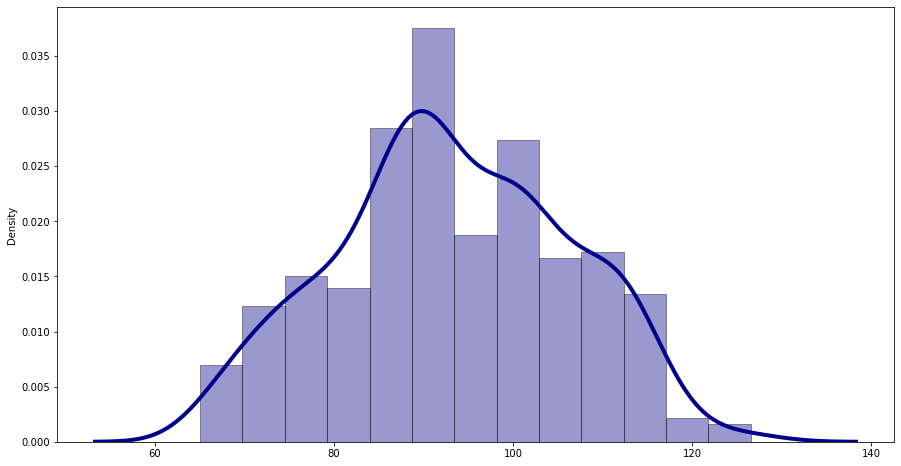

In [92]:
rcParams['figure.figsize'] = 15,8
sns.distplot(new_df, hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}
             )
plt.xlabel('')
plt.show()

from the plot above the data is somewhat normally distributed


### Time series line plot

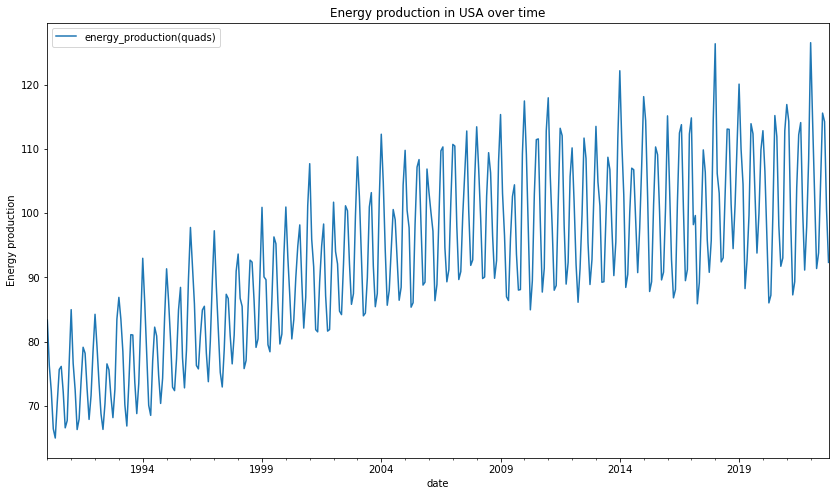

In [93]:
new_df.plot(figsize=(14,8))
plt.ylabel('Energy production')
plt.title('Energy production in USA over time')
plt.show()

We have observed a periodic and upward trend from 1990 to 2009 since the energy production increases over time and then after 2009 we have seasonal variation in our data.

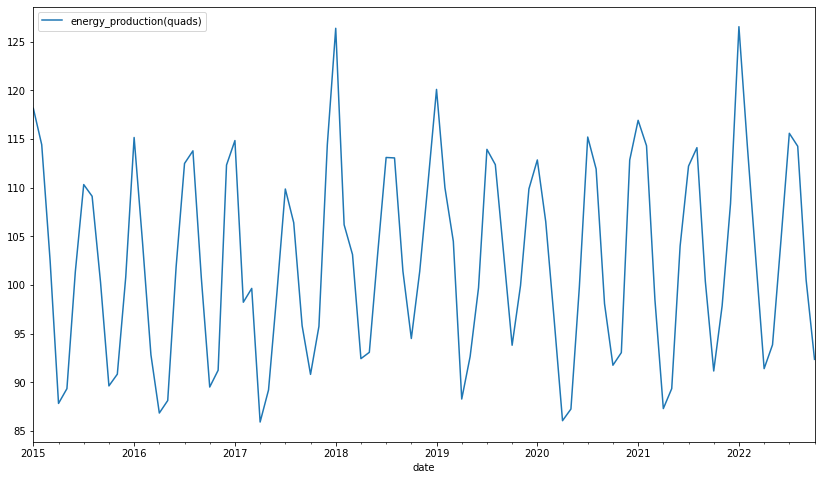

In [94]:
df_2015 =  df['2015':]
df_2015.plot(figsize=(14,8));

### Grouping and visualizing time series data

In [95]:
#Use pandas grouper to group values using annual frequency
# year_groups = new_df['2010':].groupby(pd.Grouper(freq ='A'))
# len(year_groups['date'])

#year_groups.plot(figsize=(14, 8),subplots=True, legend=True)

# #Create a new DataFrame and store yearly values in column
# s 
# us_annual = pd.DataFrame()

# for yr, group in year_groups:
#     us_annual[yr.year] = group.values.ravel()
    
# #Plot the yearly groups as subplots
# us_annual.plot(figsize = (13,8), subplots=True, legend=True);

### Checking for Trends
We can see that that there is an overall increasing trend in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences. Let's reconfirm this here using both rolling statistics and the Dickey-Fuller test

### Rolling Statistics and The Dickey-Fuller Test

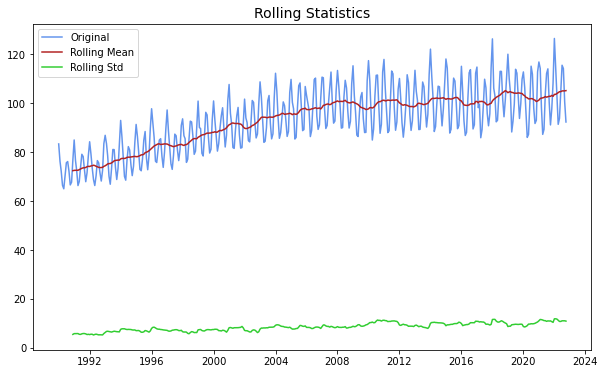

The Dickey-Fuller Test 

ADF Statistic: -2.041
p-value: 0.269
-------------------------------------------
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
-------------------------------------------
ADF > Critical Values
Failed to reject null hypothesis, time series is non-stationary.


In [96]:
def stationarity_test(df, window = 12):
    
    roll_mean = df.rolling(window).mean()
    roll_std = df.rolling(window).std()
    
    plt.figure(figsize = (10,6))
    original = plt.plot(df, color='cornflowerblue',
                    label='Original')
    mean = plt.plot(roll_mean, color='firebrick',
                    label='Rolling Mean')
    std = plt.plot(roll_std, color='limegreen',
                   label='Rolling Std')
    plt.legend(loc = 0)
    plt.title('Rolling Statistics', size = 14)
    plt.show(block=False)

    print("The Dickey-Fuller Test \n")
    
    adf = adfuller(df, autolag='AIC')
    
    print('ADF Statistic: {}'.format(round(adf[0],3)))
    print('p-value: {}'.format(round(adf[1],3)))
    print("-------------------------------------------")  
    print('Critical Values:')
    
    for key, ts in adf[4].items():
         print('{}: {}'.format(key, round(ts,3)))
    print("-------------------------------------------")
    
    if adf[0] > adf[4]["5%"]:
        print("ADF > Critical Values")
        print ("Failed to reject null hypothesis, time series is non-stationary.")
    else:
        print("ADF < Critical Values")
        print ("Reject null hypothesis, time series is stationary.")
        
stationarity_test(new_df, window = 12)

Though the variation in standard deviation is small, the mean is increasing with time and thus, this is not a stationary series.

The null-hypothesis for the test is that the time series is not stationary. The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.

## Removing trends
## Overview
Time series models work on the assumption that the time series are stationary and in this case our time series is non-stationary. We need to remove the trends to convert our time series to stationary. We will employ the following methods:

* Log transformation
* Subtracting the rolling mean
* Decompositon

### `Log transformation`

One way to enforce stationarity can be a simple log transformation to make the time series more "uniform" over time.

The advantage of taking a log transformation is that higher values are penalized more than lower values.

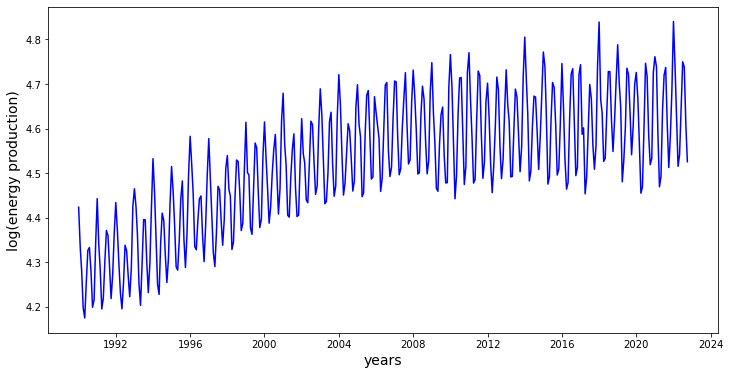

In [97]:
log_df = np.log(new_df['energy_production(quads)'])
fig = plt.figure(figsize=(12,6))
plt.plot(log_df, color='blue')
plt.xlabel('years', fontsize=14)
plt.ylabel('log(energy production)', fontsize=14)
plt.show()

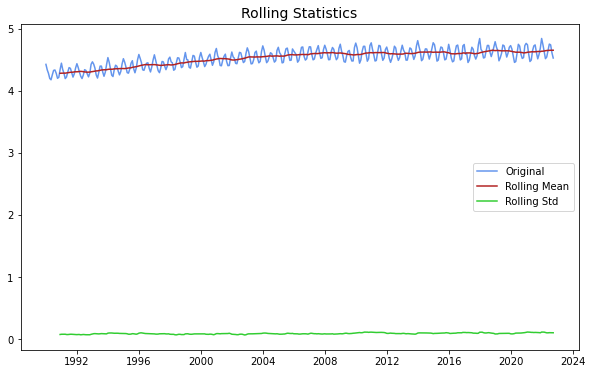

The Dickey-Fuller Test 

ADF Statistic: -2.416
p-value: 0.137
-------------------------------------------
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
-------------------------------------------
ADF > Critical Values
Failed to reject null hypothesis, time series is non-stationary.


In [98]:
# Checking for ststionarity
stationarity_test(log_df, window = 12)

### `Subtracting the rolling mean`
Since the log transformed time series data above is non stationary, we will subtract the rolling mean from the log transformed time series data in an attempt to make it stationary. 

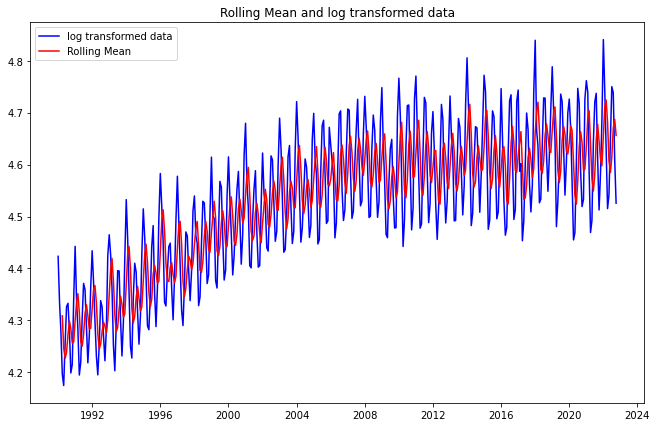

In [99]:
# calculating and visualizing rolling mean and log transformed data
roll_mean = log_df.rolling(window=4).mean()

fig = plt.figure(figsize=(11,7))
plt.plot(log_df, color='blue',label='log transformed data')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean and log transformed data')
plt.show(block=False)

In [100]:
# Subtracting rolling mean from log transformed data
logdf_minus_roll_mean = log_df - roll_mean
logdf_minus_roll_mean.head(10)

date
1990-01-01         NaN
1990-02-01         NaN
1990-03-01         NaN
1990-04-01   -0.112294
1990-05-01   -0.071860
1990-06-01    0.029465
1990-07-01    0.087945
1990-08-01    0.060174
1990-09-01   -0.019709
1990-10-01   -0.085526
Name: energy_production(quads), dtype: float64

In [101]:
# Drop the missing values from time series calculated above
logdf_minus_roll_mean.dropna(inplace=True)

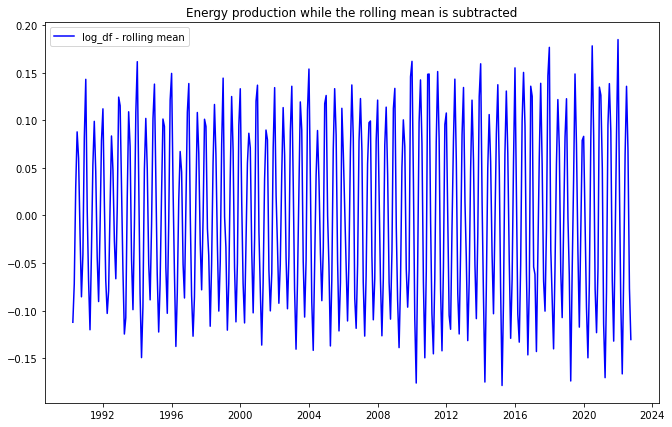

In [102]:
# Visualizing rolling mean subtracted from log transformed data
fig = plt.figure(figsize=(11,7))
plt.plot(logdf_minus_roll_mean, color='blue',label='log_df - rolling mean')
plt.legend(loc='best')
plt.title('Energy production while the rolling mean is subtracted')
plt.show(block=False)

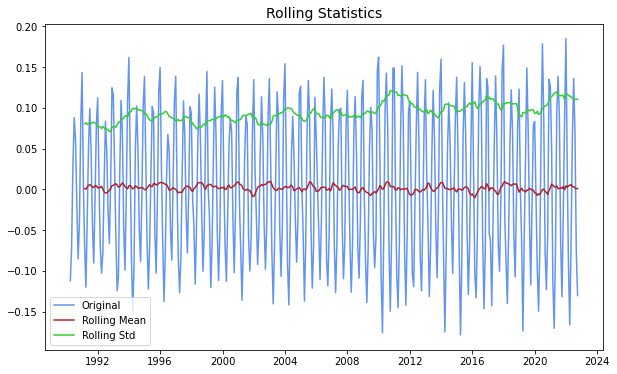

The Dickey-Fuller Test 

ADF Statistic: -7.237
p-value: 0.0
-------------------------------------------
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
-------------------------------------------
ADF < Critical Values
Reject null hypothesis, time series is stationary.


In [103]:
# Checking for stationarity
stationarity_test(logdf_minus_roll_mean, window = 12)

### `Decompositon`
Since our data is already stationary ,we decided to do decomposition in order to have a clear picture of trend,seasonal and residuals.

Time series decomposition is a mathematical procedure that transforms a time series into multiple different time series. The original time series is often split into three component series:
* Seasonal: Patterns that repeat within a fixed period.
* Trend: The underlying trend of the metrics.
* Random: Also called "noise", "irregular", or "remainder", this is the residual of the original time series after the seasonal and trend series are removed

To achieve successful decomposition, it is important to choose between the additive and multiplicative models, which requires analyzing the series.

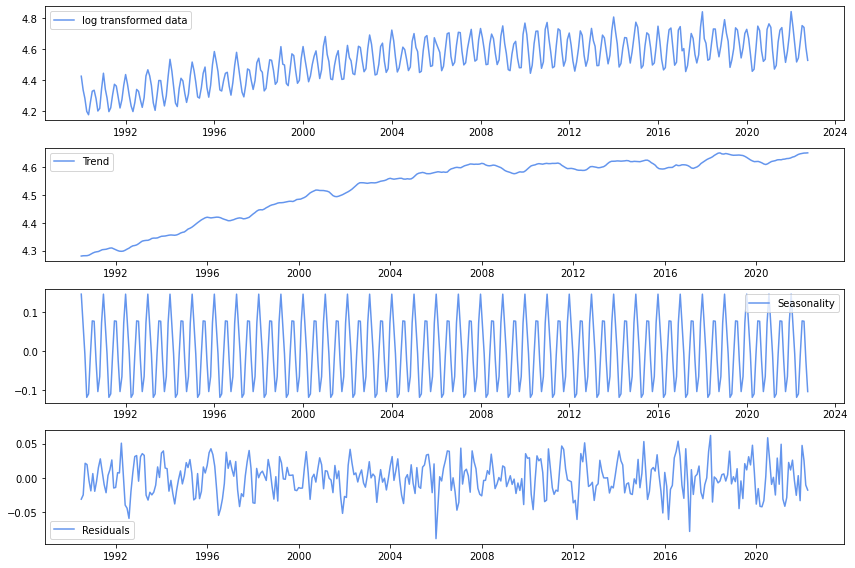

In [104]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(log_df)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(log_df, label='log transformed data', color='cornflowerblue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='cornflowerblue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='cornflowerblue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='cornflowerblue')
plt.legend(loc='best')
plt.tight_layout()

Here we can see that the trend and seasonality are separated from data and we can model the residuals.
The plot above clearly shows the upward trend of our data, along with its yearly seasonality.

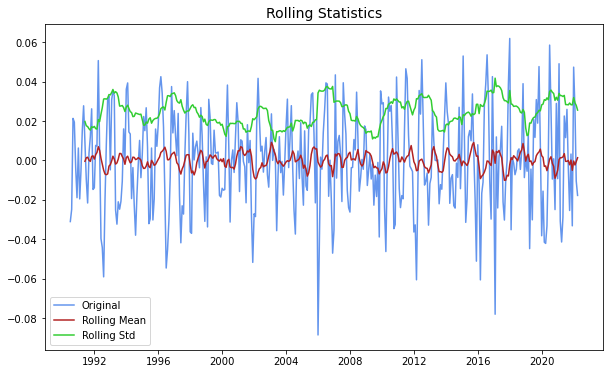

The Dickey-Fuller Test 

ADF Statistic: -9.692
p-value: 0.0
-------------------------------------------
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
-------------------------------------------
ADF < Critical Values
Reject null hypothesis, time series is stationary.


In [105]:
# Drop missing values from residuals
logdf_decompose = residual
logdf_decompose.dropna(inplace=True)
# Check stationarity
stationarity_test(logdf_decompose, window = 12)

The Dickey-Fuller test statistic is significant and very well below a (strict) 0.01 mark. So it seems reasonable to assume this time series is stationary

## Autocorrelation and  Partial Autocorrelation 
    
Autocorrelation analysis is an important step in the Exploratory Data Analysis of time series forecasting. The autocorrelation analysis helps detect patterns and check for randomness. It’s especially important when you intend to use an autoregressive–moving-average (ARMA) model for forecasting because it helps to determine its parameters. The analysis involves looking at the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

To determine the order of the model, you check the number of  lollipops above or below the confidence interval before the next lollipop enters the blue area

The ACF plot will provide answers to the following questions:

* Is the observed time series white noise/random?
* Is an observation related to an adjacent observation, an observation twice-removed, and so on?
* Can the observed time series be modeled with an MA model? If yes, what is the order?

The PACF plot will provide answers to the following question:

* Can the observed time series be modeled with an AR model? If yes, what is the order?

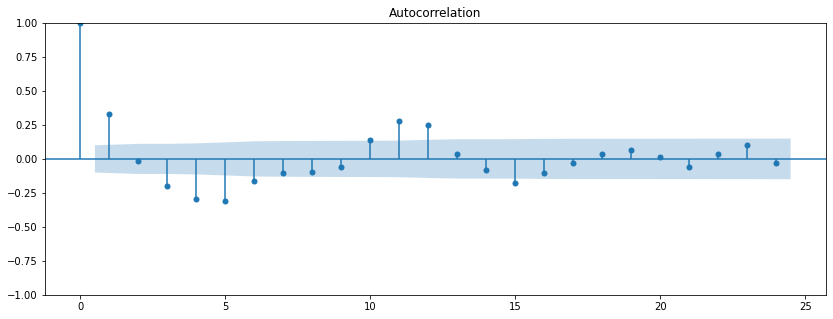

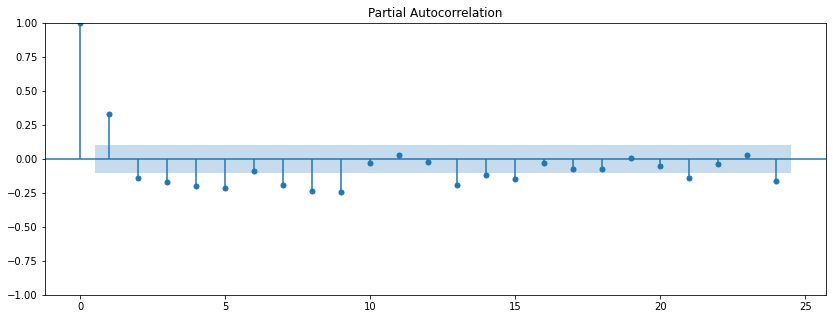

In [106]:
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_acf(logdf_decompose, lags = 24)

plot_pacf(logdf_decompose, lags=24);

#### Auto Regressive(AR) observation 
* There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.

* High degree of autocorrelation between adjacent (lag = 1) and near-adjacent (lag = 5) observations in PACF plot

* Geometric decay in ACF plot

#### Moving Average (MA)
* There are several autocorrelations that are significantly non-zero. Therefore, the time series is non-random.

* High degree of autocorrelation between adjacent (lag = 1) in ACF plot

* Geometric decay in PACF plot


Based on the observations above, AR model will have an order of 5 and the MA model an order of 1.

## Modelling
We are going to use 

#### Splitting data into train and test for modelling

We have used the first 25 years as the training dataset and the last 7 years as the testing dataset.

In [107]:
# ar_values = logdf_decompose.values
# train = ar_values[1:len(ar_values)-82] 
# test = ar_values[len(ar_values)-83:]

In [108]:
train = logdf_decompose[:-82]
test = logdf_decompose[-82:]

#### `Auto regressive model`
An autoregressive (AR) model is when a value from a time series is regressed on previous values from the same time series.

The order of the model is in the form (p, d, q):
* p refers to the order of AR which will be `5` in this case.
* d refers to the order of I which will be `0` in this case.
* q refers to the order of MA which will be `0` in this case.

In [109]:
# instantiate AR model with an order of 5
ar_model = ARIMA(train, order=(5,0,0))

# fitting the model
ar_fitted = ar_model.fit()

# print out summary information of the fit
print(ar_fitted.summary())

print('\nEstimate for the constant and for theta:\n')

# Print out the estimate for the constant and for theta

print(ar_fitted.params)

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  300
Model:                 ARIMA(5, 0, 0)   Log Likelihood                 751.186
Date:                Tue, 29 Nov 2022   AIC                          -1488.372
Time:                        17:31:58   BIC                          -1462.445
Sample:                    07-01-1990   HQIC                         -1477.996
                         - 06-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.21e-09      0.001   3.37e-06      1.000      -0.002       0.002
ar.L1          0.3637      0.057      6.353      0.000       0.251       0.476
ar.L2         -0.1669      0.060     -2.792      0.0

In [110]:
ar_predictions = ar_fitted.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ar_score = mean_squared_error(test, ar_predictions)
print('AR MSE: {}'.format(round(ar_score,4)))

AR MSE: 0.0008


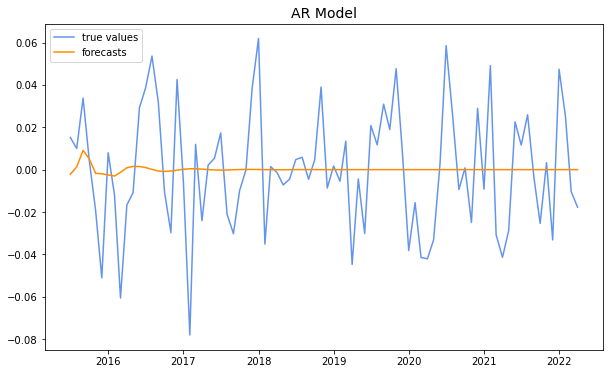

In [111]:
# visualizing the true values of the test and the predicted values
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(ar_predictions,label = "forecasts", color='darkorange')
plt.title("AR Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

#### `Moving average model`

The Moving Average model can be described as the weighted sum of today's and yesterday's noise.

The order of the model is in the form (p, d, q):
* p refers to the order of AR which will be `0` in this case.
* d refers to the order of I which will be `0` in this case.
* q refers to the order of MA which will be `1` in this case.

In [112]:
# instantiate MA model with an order of 1
ma_model = ARIMA(train, order=(0,0,1))

# fitting the model
ma_fitted = ma_model.fit()

# print out summary information of the fit
print(ma_fitted.summary())

print('\nEstimate for the constant and for theta:\n')

# Print out the estimate for the constant and for theta

print(ma_fitted.params)

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  300
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 730.598
Date:                Tue, 29 Nov 2022   AIC                          -1455.195
Time:                        17:31:58   BIC                          -1444.084
Sample:                    07-01-1990   HQIC                         -1450.749
                         - 06-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.861e-05      0.002     -0.022      0.982      -0.003       0.003
ma.L1          0.4285      0.053      8.127      0.000       0.325       0.532
sigma2         0.0004   3.22e-05     13.920      0.0

In [113]:
ma_predictions = ma_fitted.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ma_score = mean_squared_error(test, ma_predictions)
print('MA MSE: {}'.format(round(ma_score,4)))

MA MSE: 0.0008


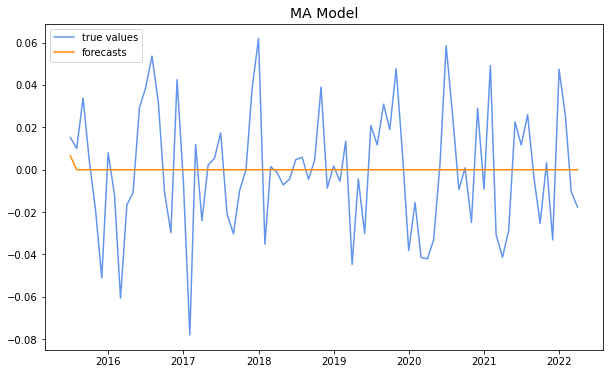

In [114]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(ma_predictions,label = "forecasts", color='darkorange')
plt.title("MA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

#### ARIMA model

The order of the model is in the form (p, d, q):
* p refers to the order of AR which will be `5` in this case.
* d refers to the order of I which will be `0` in this case.
* q refers to the order of MA which will be `1` in this case.

In [115]:
arima_model = ARIMA(train, order=(5,0,1))
arima_fitted = arima_model.fit()

arima_predictions = arima_fitted.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
arima_score = mean_squared_error(test, arima_predictions)
print('AR MSE: {}'.format(round(arima_score,4)))

AR MSE: 0.0008


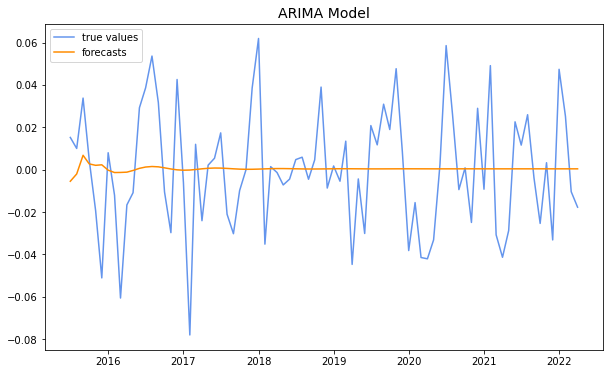

In [116]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(arima_predictions,label = "forecasts", color='darkorange')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

In [117]:
new_df

,energy_production(quads)
date,
1990-01-01,83.3773
1990-02-01,76.2628
1990-03-01,72.3211
1990-04-01,66.4534
1990-05-01,65.0260
...,...
2022-06-01,104.5230
2022-07-01,115.5747
2022-08-01,114.2425


In [136]:
ts = new_df.copy()
ts.reset_index(inplace=True)
ts.rename(columns={'date':'ds','energy_production(quads)':'y'},inplace =True)
ts.set_index('ds',inplace=True)
ts.head()

,y
ds,
1990-01-01,83.3773
1990-02-01,76.2628
1990-03-01,72.3211
1990-04-01,66.4534
1990-05-01,65.0260


In [ ]:
!pip install pystan
!pip install fbprophet

In [ ]:
from fbprophet import Prophet

# instantiate the model and fit the timeseries
prophet = Prophet()
prophet.fit(ts)

# create a future data frame 
future = prophet.make_future_dataframe(periods=24)
forecast = prophet.predict(future)

# display the most critical output columns from the forecast
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()

# plot
fig = prophet.plot(forecast)